In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor
# Library to overcome Warnings.
import warnings
warnings.filterwarnings('ignore')

# set creation

In [5]:
df = pd.read_feather("/kaggle/input/annual-istanbul-transport-data-2022-wout-marine/final_set.feather")

In [6]:
lines_g = df.groupby('line')["number_of_passenger"].sum().reset_index().sort_values(by="number_of_passenger",ascending=False)
top15 = lines_g[:15]
df['top_lines_indicator'] = df['line'].isin(top15.line).astype(int)
df = df[df['line'] != "KADIKOY-EMINONU"] # tagged wrong
df['transport_type_id'] = df['transport_type_id'].replace({2:1,1:0}) # make binary 
df['transfer_type_b'] = df['transfer_type'].replace({'Normal':1,'Aktarma':0}) # make binary
df['line_encoded'], _ = df['line'].factorize() # so i can use in the model
df = df.set_index('transition_date') # set the date as index

In [7]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['day_of_month'] = df.index.day
    return df

df = create_features(df)

In [8]:
model_data = df[['transition_hour', 'transport_type_id', 'day', 'line_encoded',
                  'transfer_type_b','number_of_passenger','month','dayofyear','day_of_month','top_lines_indicator']]

model_df = pd.DataFrame(model_data)

In [9]:
X = model_data.drop('number_of_passenger', axis=1)  # Features
y = model_data["number_of_passenger"]  # Target

## model creation

In [11]:
categorical_features = ['transition_hour', 'transport_type_id', 'day',
                  'transfer_type_b','month','top_lines_indicator']
reg = HistGradientBoostingRegressor(max_iter=400, random_state=42, min_samples_leaf=5, l2_regularization=0.5,max_depth=7,
                                    categorical_features=categorical_features,learning_rate=0.1)

In [13]:
# Initialize lists to store metrics and predictions
fold_maes = []
fold_rmses = []
fold_r2s = []

# Initialize time series cross-validation
tscv = TimeSeriesSplit(n_splits=10)

# iterate through each fold
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # fit the model for this fold
    reg.fit(X_train, y_train)

    predictions = reg.predict(X_test)

    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions, squared=False)
    r2 = r2_score(y_test, predictions)

    # Ssore the metrics for each fold
    fold_maes.append(mae)
    fold_rmses.append(mse)
    fold_r2s.append(r2)

print(f"Overall MAE: {np.mean(fold_maes)} (+/- {np.std(fold_maes)})")
print(f"Overall RMSE: {np.mean(fold_rmses)} (+/- {np.std(fold_rmses)})")
print(f"Overall R2: {np.mean(fold_r2s)} (+/- {np.std(fold_r2s)})")

Overall MAE: 102.49685183695938 (+/- 8.71364638689728)
Overall RMSE: 349.62365621615436 (+/- 89.502047590275)
Overall R2: 0.9607993684793857 (+/- 0.02440107764067754)


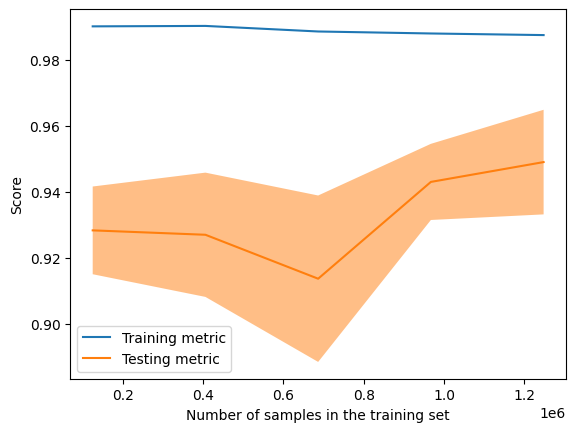

In [15]:
from sklearn.model_selection import LearningCurveDisplay
# Plot learning curve with training and validation scores
tscv = TimeSeriesSplit(n_splits=5)
LearningCurveDisplay.from_estimator(reg, X, y, n_jobs=2,score_type='both',cv=tscv) 